In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xtrack as xt
import xcoll as xc
import xpart as xp
import xobjects as xo

In [2]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
# env = line.env
# #crab cavities: acfcah.61738 and acfcah.61739
# crab1 = xt.CrabCavity(crab_voltage=1e6, frequency = line['actcse.31632'].frequency, lag=0)
# crab2 = xt.CrabCavity(crab_voltage=1e6, frequency = line['actcse.31632'].frequency, lag=0)
# env.elements['acfcah.61738'] = crab1
# env.elements['acfcah.61739'] = crab2
tt = line.get_table()

In [4]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tt = line.get_table()
    tw = line.twiss()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [5]:
num_particles = 1000
num_turns = 3000
plane = 'H'
amplitude_adt = 0.08
nemitt_x = 2e-6
nemitt_y = 2e-6

In [6]:
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)
tidp = install_tidp(line, block_mvt=29e-3)
tcsm = install_tcsm(line)

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [7]:
adt = xc.BlowUp.install(line, name=f'adt_{plane}_blowup', at_s=line.get_s_position('adkcv.32171'), plane=plane, stop_at_turn=num_turns,
                        amplitude=amplitude_adt, use_individual_kicks=False)

In [8]:
tw = line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)

In [9]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.2333663781336932m.
... distance to target bunch length: -2.2228e-01
... distance to target bunch length: 4.5424e-03
... distance to target bunch length: 4.3382e-03
... distance to target bunch length: -6.6565e-03
... distance to target bunch length: 2.0203e-03
... distance to target bunch length: -5.7185e-04
... distance to target bunch length: 1.0779e-04
... distance to target bunch length: 4.7891e-06
... distance to target bunch length: -2.0504e-09
... distance to target bunch length: 9.6490e-08
--> Bunch length: 0.22399999794961262
--> Emittance: 0.34347649813344366


In [10]:
adt.calibrate_by_emittance(nemitt=nemitt_x, twiss=tw)

In [11]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.scattering.enable()
adt.activate()
line.track(part, num_turns=num_turns, time=True, with_progress=1)
adt.deactivate()
line.scattering.disable()
print(f"Done tracking in {line.time_last_track:.1f}s.")

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/3000 [00:00<?, ?it/s]

Done tracking in 372.4s.


In [12]:
ThisLM = xc.LossMap(line = line, line_is_reversed=False, part=part, interpolation=False)

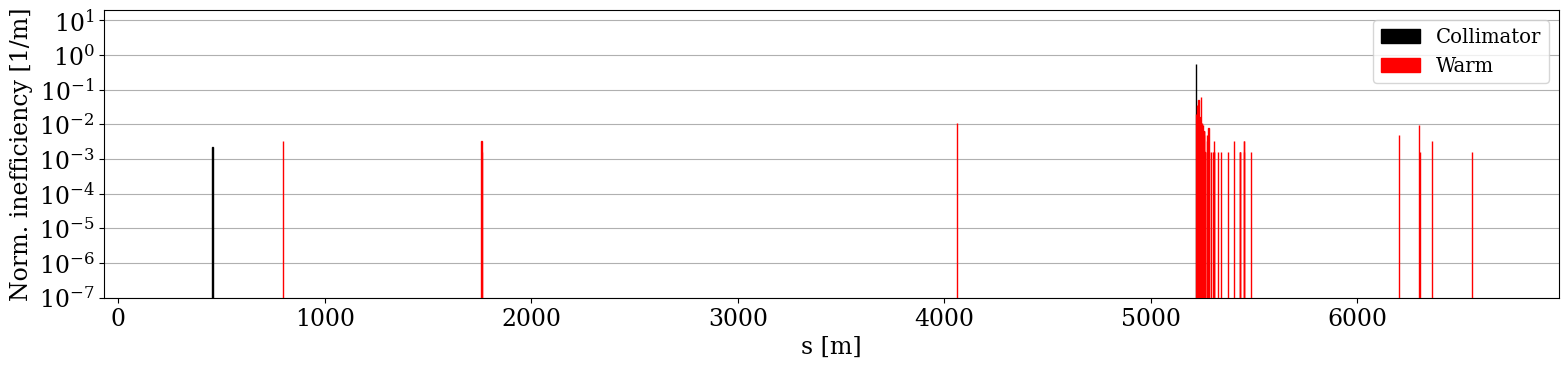

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='s [m]', ylabel='Norm. inefficiency [1/m]'>)

In [13]:
ThisLM.plot()

In [14]:
np.unique(part.at_turn, return_counts=True)

(array([  51,  138,  140,  169,  183,  187,  191,  194,  195,  199,  200,
         203,  218,  448,  652,  718,  795,  803,  845,  878,  891,  895,
         896,  898,  907,  911,  912,  916,  920,  922,  924,  926,  927,
         928,  929,  931,  933,  934,  937,  938,  941,  945,  954,  955,
         962,  963,  971,  974, 1519, 1527, 1531, 1532, 1620, 1623, 1624,
        1626, 1627, 1628, 1632, 1636, 1637, 1641, 1649, 1651, 1653, 1654,
        1658, 1661, 1662, 1665, 1668, 1670, 1673, 1674, 1677, 1678, 1679,
        1680, 1682, 1683, 1685, 1686, 1687, 1690, 1691, 1695, 1696, 1699,
        1701, 1703, 1704, 1706, 1707, 1708, 1710, 1711, 1712, 1713, 1723,
        1728, 1731, 1732, 1736, 1737, 1740, 1741, 1745, 1749, 1751, 1752,
        1753, 1754, 1757, 1763, 1799, 1801, 1803, 1804, 1813, 1819, 1837,
        1839, 1845, 1847, 1853, 1862, 1863, 1864, 1865, 1866, 1867, 1868,
        1871, 1872, 1873, 1874, 1877, 1879, 1886, 1887, 1896, 1898, 1912,
        1914, 1920, 1921, 1922, 1925, 

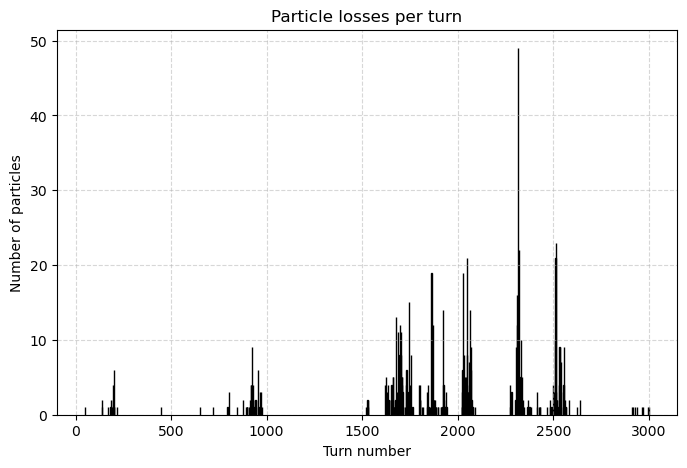

In [15]:
mask = part.state > 0
unique_turns, counts = np.unique(part.at_turn[~mask], return_counts=True)

# Plot histogram-like bar chart
plt.figure(figsize=(8, 5))
plt.bar(unique_turns, counts, width=1.0, edgecolor='black')
plt.xlabel("Turn number")
plt.ylabel("Number of particles")
plt.title("Particle losses per turn")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [16]:
np.unique(part.state, return_counts=True)

(array([-331,    0,    1]), array([646, 267,  87]))

In [17]:
87/1000

0.087